<a href="https://colab.research.google.com/github/jav0927/course-v3/blob/master/JAV_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
NUM_PARALLEL_UNITS = 4
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *


# Data Preparation

In [0]:
# Download {Pasal 20007 database}
path = untar_data(URLs.PASCAL_2007); path.ls()

[PosixPath('/root/.fastai/data/pascal_2007/train'),
 PosixPath('/root/.fastai/data/pascal_2007/test'),
 PosixPath('/root/.fastai/data/pascal_2007/test.json'),
 PosixPath('/root/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/root/.fastai/data/pascal_2007/train.json')]

In [0]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
img_y_dict = dict(zip(tot_im_names, tot_truths))

Define a function, based on the dictionary, to use in a Fastai Data Block to structure the input data

In [0]:
truth_data_func = lambda o: img_y_dict[o.name]

# Create Fastai DataBunch

In [0]:
sz=224
bs=64

In [0]:
np.random.seed(35)
data = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct()
        .label_from_func(truth_data_func)
        .transform(get_transforms(max_rotate=3.,max_zoom=1.,p_affine=0.5,p_lighting=0.5),size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

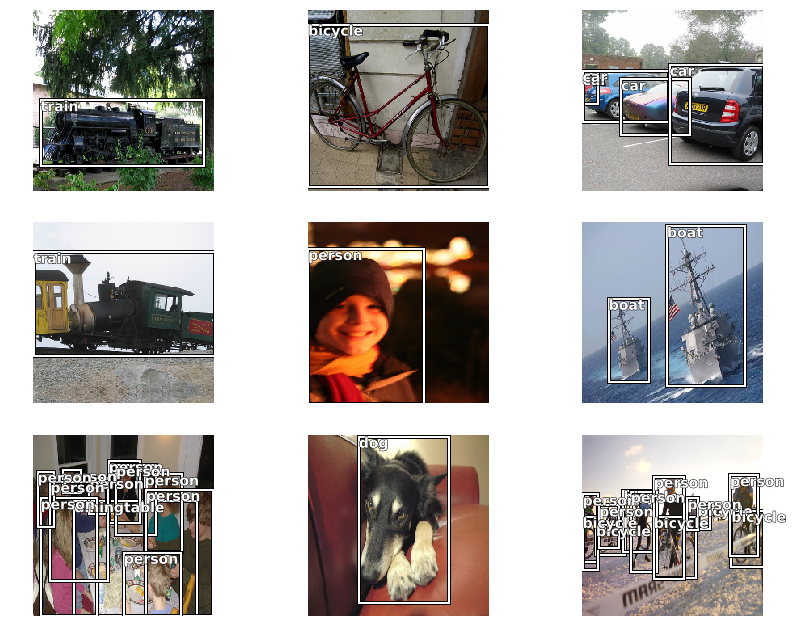

In [0]:
data.show_batch(rows=3, figsize=(12,9))

### Show single simple image

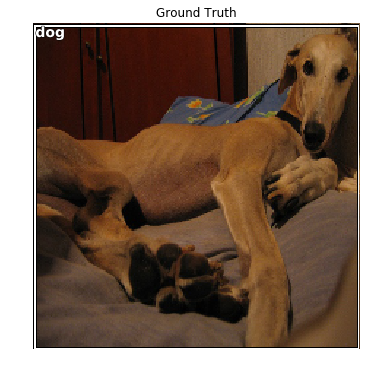

In [0]:
idx = 9

xb, yb= next(iter(data.valid_dl))

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions

In [0]:
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert box to fastai style top left bot right anchor box
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

#anchor (center,h,w)
#fastai y (top left bot right)
#convert activation to fastai y style
#assume activation is (center,h,w)
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

# Model

To solve this object detection problem, we are going to create a custom model using Torch.
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detetion. For initial design and testing, we use ResNet18, as it is computationally lighter (and I dont have a GPU). It will be upgraded when we do further tests.

In [0]:
# model 
f_model = models.resnet34

In [0]:
# Number of classes in the data set
no_cls = len(data.classes); no_cls

21

In [0]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride, bias=True)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
    
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [0]:
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.25)

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1) # H=7, W=7
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 x 4
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 x 2
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 x 1
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

# Create Anchors

In [0]:
anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)

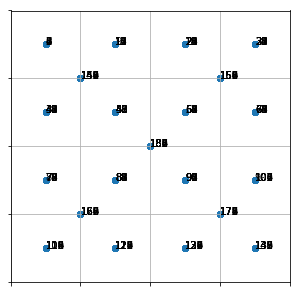

In [0]:
show_anchors(anchors,(4,4))

# SSD Loss

---


In [0]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
def bceloss(pred,target,num_classes,focal_loss=False):
    #print(target.shape)
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    #print(t.shape,p.shape)
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

def single_ssd_loss(pbox,plabel,box,label):
    #handle ground truth object, from any shape to feature map size
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) #iou take both inputs in fastai style
    bbox,clas = un_pad(box,label) #y from databunch already in fastai style
    overlaps = iou(bbox,base_box.cuda())
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    #map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    pos = gt_overlaps > 0.4
    gt_clas[1-pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #vector of size of # of bbox
    pos_idx = torch.nonzero(pos)[:,0] #for which cells that gt bbox exists
    gt_bbox = bbox[gt_idx]
    
    #map pred bounding box to anchor, final box = pred box + anchor box
    p_final_box = act_to_bbox(pbox,anchor_box.cuda()) #grid size over # of anchor box along single axis
    
    #cal loss
    #L1loss
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.cuda()
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss

In [0]:
 loss_f = ssd_loss

### Learner

In [0]:
md = ssd_model(f_model, k=9, no_cls=no_cls)

In [0]:
learn = Learner(data, md, loss_func=loss_f)

# Fit

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 7.59E-02


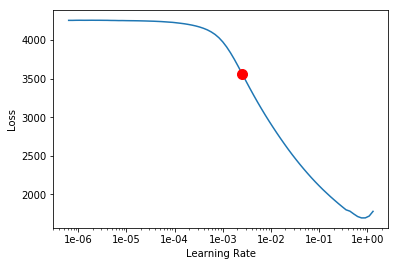

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-02

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,39.479050,37.531631,01:35
1,39.116348,37.599442,01:35
2,38.412399,37.628708,01:35
3,37.750237,36.297203,01:34
4,37.137199,40.422306,01:34


In [0]:
#learn.save('SSD_one')
mdl_save_name = ('SSD_one')
path = F'/content/gdrive/My Drive/{mdl_save_name}'
torch.save(f_model.state_dict(), path)

In [0]:
#learn.load('SSD_one')

#### Test Loss

In [0]:
##Test Loss
x,y = next(iter(data.valid_dl)) 

In [0]:
batch = learn.model(x)

In [0]:
bx, cl = batch

In [0]:
bx.shape, cl.shape

In [0]:
ssd_loss(cl, y, True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


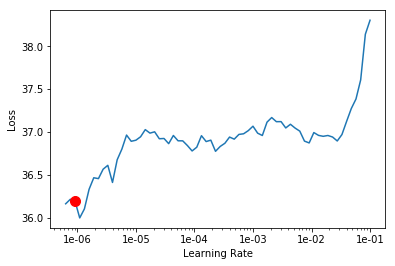

In [0]:
learn.split(lambda m: (m.body[7],m.drop))
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lrs = [2e-6, 2.5e-5, 2.5e-3]

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(2e-6, 2.5e-5, 2.5e-3))

epoch,train_loss,valid_loss,time
0,36.706345,39.568893,01:37
1,36.779114,36.661205,01:37
2,36.621822,39.414879,01:37
3,36.779770,40.240028,01:37
4,36.721909,35.828594,01:37


In [0]:
learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 9.12E-02


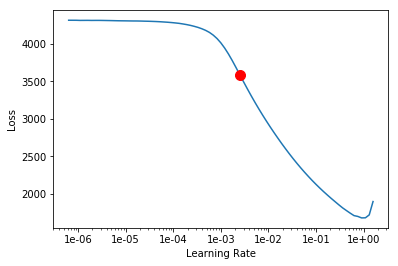

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,805.035706,130.323654,01:37
1,215.329590,39.315105,01:36
2,88.165794,39.048325,01:36
3,53.441418,37.682667,01:36
4,42.974564,36.206486,01:35
5,38.742599,35.046234,01:36
6,36.725948,33.383141,01:35
7,34.829136,31.730755,01:36
8,33.235096,30.511372,01:35
9,32.280922,30.187782,01:35


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze', strict=True)

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,32.212017,31.011734,02:46
1,32.567844,31.901972,02:44
2,32.080414,30.952578,02:43
3,30.499128,27.910080,02:43
4,28.910650,26.542883,02:44
5,27.614166,25.272236,02:44
6,26.369781,24.361664,02:44
7,25.095901,23.823404,02:43
8,24.160086,23.395521,02:43
9,23.655699,23.317232,02:43


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2', strict=True)

In [0]:
learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,23.490263,23.443405,01:48
1,24.199438,25.704252,01:47
2,25.243721,25.458397,01:48
3,25.502745,26.666721,01:46
4,25.187181,24.491810,01:46
5,24.140892,23.639172,01:44
6,23.291391,23.558104,01:44
7,22.510284,22.731516,01:43
8,21.878952,22.352940,01:42
9,21.483656,22.212563,01:43


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_3')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_3', strict=True)

In [0]:
learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,21.979179,19.600460,01:37
1,22.701887,20.918032,01:37
2,23.789499,23.700809,01:37
3,23.954632,21.339115,01:37
4,23.368063,21.324295,01:37
5,22.804049,20.672152,01:37
6,22.263077,20.470076,01:37
7,21.366898,19.813692,01:37
8,20.879011,19.569803,01:37
9,20.455755,19.644293,01:37


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_4')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_4', strict=True)

In [0]:
learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,20.304493,19.917582,01:37
1,20.719479,21.696104,01:37
2,22.061090,21.767263,01:37
3,22.584209,22.114672,01:37
4,22.177210,21.259851,01:37
5,21.563557,20.925056,01:37
6,21.036184,20.630392,01:37
7,20.269741,19.969727,01:37
8,19.700214,19.612392,01:37
9,19.330761,19.617710,01:37


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_5')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_5', strict=True)

In [0]:
learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-8, 1e-2))

epoch,train_loss,valid_loss,time
0,19.441856,19.988079,01:36
1,20.076706,21.259441,01:37
2,21.084547,22.173931,01:37
3,22.486807,22.061037,01:37
4,21.891863,21.445532,01:38
5,21.305920,25.331684,01:37
6,20.424763,20.214998,01:37
7,19.745186,19.791527,01:37
8,19.122829,19.763844,01:37
9,18.746246,19.596760,01:38


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_6')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_6', strict=True)

# Filter Spurious Boxes

### Display predicted images and ground truth

In [0]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

torch.Size([64, 3, 224, 224])

In [0]:
# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)

In [0]:
# Select sample image and unpad it
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
t_bbox,t_clas

(tensor([[-0.1840, -0.1240,  0.4933,  0.2000]], device='cuda:0'),
 tensor([14], device='cuda:0'))

In [0]:
data.classes

In [0]:
# Predicted class
p_cls_test = preds[1][idx][:,1:].max(dim=1)
p_cls_test

torch.return_types.max(...)

In [0]:
# Threshold
idx_clas = p_cls_test[0].sigmoid() > 0.1
idx_clas

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.uint8)

In [0]:

p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
p_f_clas

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0, 15, 15,  0,
         0,  0,  0, 15,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0, 14, 15,  0, 15, 15, 14,
         2, 15,  0, 14, 15,  0,  2, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')

In [0]:
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

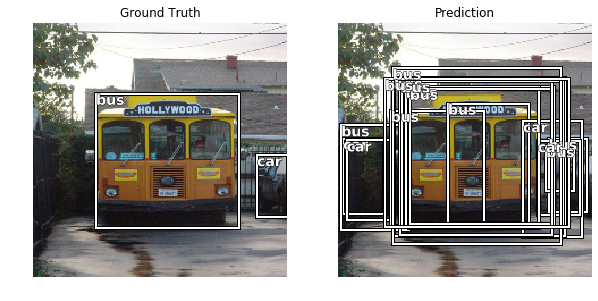

In [0]:
show_img_by_ndx(60)

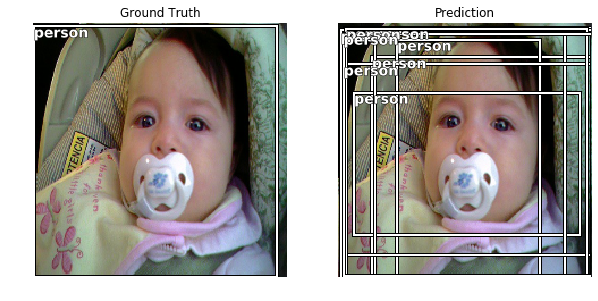

In [0]:
show_img_by_ndx(2)

## NMS

In [0]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [0]:
import gc
gc.collect()

11261

In [0]:
x,y = next(iter(data.valid_dl))
#y = torch.FloatTensor(y)7
batch = learn.model(x)
b_bb, b_clas = batch
#x = to_np(x)

In [0]:
y[0].shape, y[1]

(torch.Size([64, 18, 4]), tensor([[ 0,  0,  0,  ...,  0,  0, 14],
         [ 0,  0,  0,  ..., 15, 15, 15],
         [ 0,  0,  0,  ...,  0,  0, 15],
         ...,
         [ 0,  0,  0,  ...,  0,  0, 12],
         [ 7,  7,  7,  ...,  4,  4,  7],
         [ 0,  0,  0,  ..., 16, 16, 16]], device='cuda:0'))

In [0]:
print('x, y:', y[0].shape, y[1].shape)
print('grid_sizes:',grid_sizes.shape)
#print('grd_szs:', grd_szs.shape)
print('anchors:', anchors.shape)
print('y_hat - boxes, class:', b_bb.shape, b_clas.shape)


x, y: torch.Size([64, 18, 4]) torch.Size([64, 18])
grid_sizes: torch.Size([189, 1])
anchors: torch.Size([189, 4])
y_hat - boxes, class: torch.Size([64, 189, 4]) torch.Size([64, 189, 21])


In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [0]:
id2cat = list(data.classes)

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
def show_img(im, figsize=None, ax=None):
    #****
    #import pdb; pdb.set_trace()
    #*****
    im = to_np(im)
    im = im.transpose(1,2,0)
    
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax
  
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.2):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
  
    tb = to_np((bbox*224).long())
    tc = clas  # It was already an array. Before it was to_np(clas)
    pt = to_np(prs) if prs is not None else None
    
    return show_ground_truth(ax, ima, tb,
         tc, pt, thresh)
  
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn).cuda()
    grd_szs = grid_sizes.type(torch.float).cuda()
    
    #actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_centers = (actn_bbs[:,:2]/2 * grd_szs) + anchors[:,:2].cuda()
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:].cuda()
    return hw2corners(actn_centers, actn_hw)
  
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]
  

In [0]:

def show_nmf(idx):
    #ima=data.denorm(x)[idx]
    ima = vision.Image(denormalize(x[idx],*tensor(imagenet_stats)))
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = np.transpose(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)
 
    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

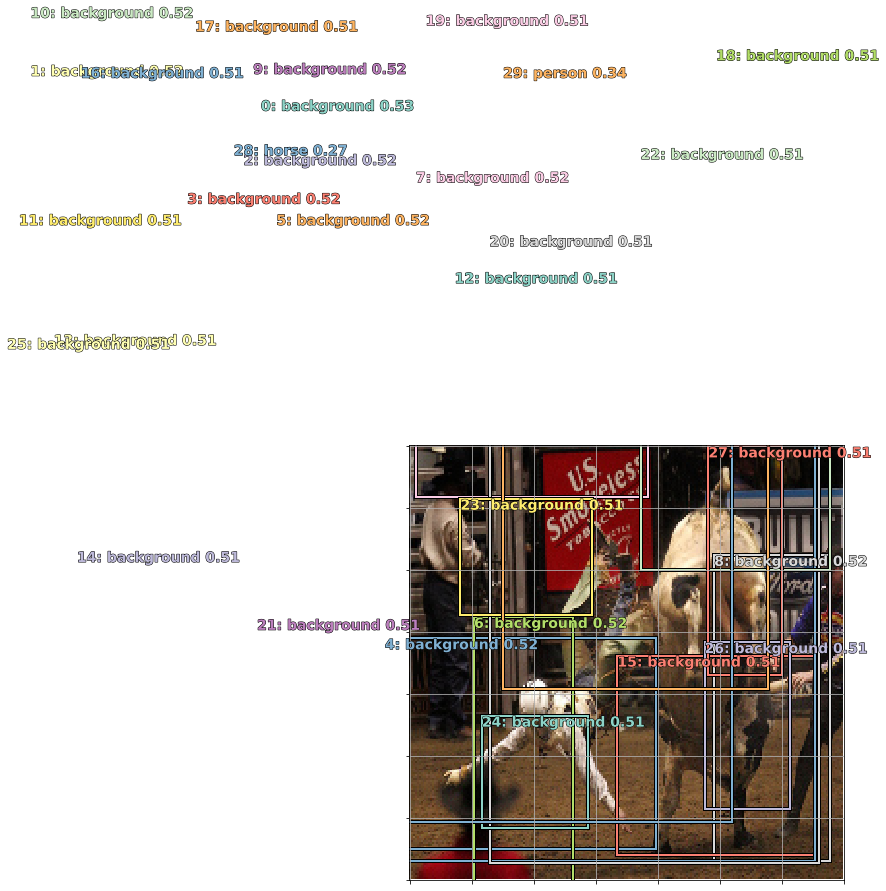

In [0]:
for i in range(1,2): show_nmf(i)
  

# FIN